In [7]:
import geopandas
import rioxarray
import pathlib
import matplotlib
import numpy
import shapely
import scipy.spatial
import xarray
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

Load in files - note using REC2.4 only because Ude used this when deriving population and slope over catchment patches. In future we should be using REC2.5

In [9]:
base_path = pathlib.Path(r"C:\Users\pearsonra\Documents\data\river_bathemetry")
rec2 = geopandas.read_file(base_path / r"rec_domains\REC2_12Feb2014(Rec2.3)\rec2_rivers12feb14.shp")

SyntaxError: unexpected character after line continuation character (Temp/ipykernel_2392/407405926.py, line 2)

Specify relevant fids

In [10]:
rec2_waikanae_id = 9253579

Cycle through the nodes from the initial ID using the NextDownID that matches the earch above and putting into a list. This can become a new GeoPandasDataframe of all polylines in a from coast to the upper catchment.

## A function to extract all polylines associated with a river

In [11]:
rec2.columns

Index(['HydroID', 'NextDownID', 'CATAREA', 'CUM_AREA', 'nzsegment', 'Enabled',
       'LENGTHDOWN', 'Headwater', 'Hydseq', 'StreamOrde', 'euclid_dis',
       'upElev', 'downElev', 'upcoordX', 'downcoordX', 'downcoordY',
       'upcoordY', 'sinuosity', 'nzreach_re', 'headw_dist', 'segslpmax',
       'segslpmean', 'LID', 'reachtype', 'FROM_NODE', 'TO_NODE', 'Shape_Leng',
       'geometry'],
      dtype='object')

In [12]:
def get_down_stream_reaches(rec: geopandas.GeoDataFrame, reach_id: int, reaches: geopandas.GeoDataFrame, i: int):
    if i>8000:
        print(f"Reached recursion limit at: {i}")
        return reaches, i
    i += 1
    down_stream_reaches = rec[rec['NextDownID']==reach_id]
    reaches = reaches.append(down_stream_reaches)
    for index, down_stream_reach in down_stream_reaches.iterrows():
        if not down_stream_reach['Headwater']: 
            reaches, i = get_down_stream_reaches(rec=rec, reach_id=down_stream_reach['nzsegment'], reaches=reaches, i=i)
    
    return reaches, i

## Generate shape files for the Waikanae river

<AxesSubplot:>

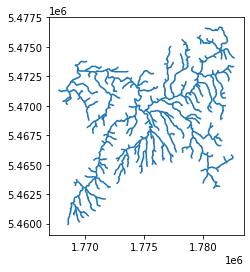

In [13]:
area_threshold = 100_000_000 # 10_000_000. 100_000_000
waikanae_river = rec2[rec2['nzsegment']==rec2_waikanae_id]
waikanae_river, i = get_down_stream_reaches(rec2, rec2_waikanae_id, waikanae_river, i=0)
waikanae_river.plot()

### Extract flat region above area threshold
Extract teh flat reaches with more upstream area than the set threshold

<AxesSubplot:>

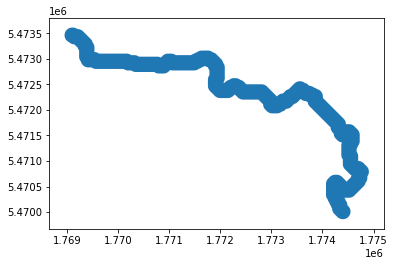

In [14]:
flat_waikanae_river_area = waikanae_river[waikanae_river['CUM_AREA']>area_threshold]
flat_waikanae_river_area_polygon = geopandas.GeoDataFrame(geometry=flat_waikanae_river_area.buffer(150))
flat_waikanae_river_area_polygon['label'] = 1
flat_waikanae_river_area_polygon = flat_waikanae_river_area_polygon.dissolve(by='label')
flat_waikanae_river_area_polygon.plot()

### Save out Waikanae river shapefiles

In [16]:
#waikanae_river.to_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_polyline.geojson")
#flat_waikanae_river.to_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_flat_polyline.geojson")
#flat_waikanae_river_polygon.to_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_flat_polygon.geojson")
#flat_waikanae_river_area_polygon.to_file(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_polygon_{area_threshold}.geojson")

# Separate out River - edge detection - after manual placement of river in QGIS based of DEM & satallite
At polyline nodes - calculate perpindicular transect - look at slope change along this - cell to cell & slope change
* calculate width
* calculate avg elevation of 'river' bit

In [17]:
transect_length = 100 # in both directions
resolution = 1
sampling_resolution = 10 # transect spacing up river

## Waikanae

In [18]:
waikanae_manual_rivers = geopandas.read_file(base_path / "waikanae\manual_river_centre_100000000\manual_river_centre_100000000.geojson")
with rioxarray.rioxarray.open_rasterio(base_path / r"waikanae\clipped\results\1m_100000000_gnd.nc", masked=True) as waikane_dem:
            waikane_dem.load()
with rioxarray.rioxarray.open_rasterio(base_path / r"waikanae\clipped\results\1m_100000000_gnd_linear.nc", masked=True) as waikane_dem_linear:
            waikane_dem_linear.load()

### Get perpindicular sample lines from manual rivers
### Subsample every ten metres

In [19]:
def subsample_channels(channel_centre_lines: geopandas.GeoDataFrame, channel_id: int, sampling_resolution: float):
    line_string = channel_centre_lines.loc[channel_id]['geometry']
    sampled_channel_centre_lines = geopandas.GeoDataFrame({'id': [channel_id], 'geometry': shapely.geometry.LineString(
        [channel_centre_lines.loc[channel_id]['geometry'].interpolate(i * sampling_resolution) for i in range(int(numpy.ceil(channel_centre_lines.loc[channel_id]['geometry'].length/sampling_resolution)))])},
                                                          crs = channel_centre_lines.crs)
    return sampled_channel_centre_lines

In [20]:
sampled_waikanae_manual_rivers=subsample_channels(waikanae_manual_rivers, 0, sampling_resolution)

### Sample elevations along main channel

In [22]:
def transects_along_reaches(channel_centre_lines: geopandas.GeoDataFrame, channel_id: int, transect_length: float):
    transects = {'geometry':[], 'nx':[], 'ny':[], 'midpoint': [], 'length': []}
    (x_array, y_array) = channel_centre_lines.loc[channel_id].geometry.xy
    for i in range(len(x_array)-1):
        # calculate midpoint
        midpoint = [(x_array[i] + x_array[i+1])/2, (y_array[i] + y_array[i+1])/2]

        # caclulate slope along segment
        dx = (x_array[i+1] - x_array[i])/numpy.sqrt((x_array[i+1] - x_array[i])**2 + (y_array[i+1] - y_array[i])**2)
        dy = (y_array[i+1] - y_array[i])/numpy.sqrt((x_array[i+1] - x_array[i])**2 + (y_array[i+1] - y_array[i])**2)
        
        # record nirmal to a segment nx and ny
        transects['nx'].append(-dy)
        transects['ny'].append(dx)

        # calculate transect - using effectively nx and ny
        transects['geometry'].append(shapely.geometry.LineString([[midpoint[0] + transect_length * dy, midpoint[1] - transect_length * dx],
                                                      midpoint,
                                                      [midpoint[0] - transect_length * dy, midpoint[1] + transect_length * dx]]))
        transects['midpoint'].append(shapely.geometry.Point(midpoint))
        # record the length of the line segment
        transects['length'].append(numpy.sqrt((x_array[i+1]-x_array[i])**2 + (y_array[i+1] - y_array[i])**2))
    transects = geopandas.GeoDataFrame(transects, crs=channel_centre_lines.crs) 
    return transects

In [23]:
transects = transects_along_reaches(sampled_waikanae_manual_rivers, 0, transect_length)

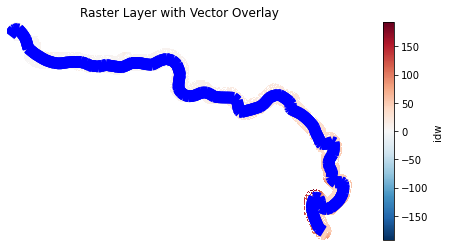

In [24]:
f, ax = matplotlib.pyplot.subplots(figsize=(11, 4))

waikane_dem.plot(ax=ax)

waikanae_manual_rivers[waikanae_manual_rivers['id']==0].plot(color='green', linewidth=3, ax=ax)

transects.plot(color='blue',
                    edgecolor='teal',
                    linewidth=2,
                    ax=ax)

ax.set(title="Raster Layer with Vector Overlay")
ax.axis('off')
matplotlib.pyplot.show()

### Sample elevations along each transect at the resolution

In [25]:
def sample_from_transects(transects: geopandas.GeoDataFrame, dem: xarray.core.dataarray.DataArray, transect_length: float, resolution: float):
    
    # number of transect samples - ensure be odd
    number_of_samples = int(numpy.floor(transect_length/resolution) * 2 - 1)
    sample_index_array = numpy.arange(-numpy.floor(number_of_samples/2), numpy.floor(number_of_samples/2) + 1, 1)
    
    transect_samples = {'elevations': [], 'xx': [], 'yy': [], 'min_z':[]}
    
    # create tree to sample from
    grid_x, grid_y = numpy.meshgrid(dem.x, dem.y)
    xy_in = numpy.concatenate([[grid_x.flatten()], [grid_y.flatten()]], axis=0).transpose()
    tree = scipy.spatial.KDTree(xy_in)
    
    # cycle through each transect - calculate sample points then look up
    for index, row in transects.iterrows():
        #calculate xx, and yy points to sample at
        if row['nx'] == 0:
            xx=row.midpoint.x + numpy.zeros(number_of_samples)
        else:
            xx=row.midpoint.x + sample_index_array * resolution * row['nx']
        if row['ny'] == 0:
            yy=row.midpoint.y + numpy.zeros(number_of_samples)
        else:
            yy=row.midpoint.y + sample_index_array * resolution * row['ny']
        
        # Sample the elevations at along the transect
        xy_points = numpy.concatenate([[xx], [yy]], axis=0).transpose()
        assert len(xy_points) == 199, f"{len(xx)}, {len(yy)}, {len(xy_points)}, {row['nx']}, {row['ny']}"
        distances, indices = tree.query(xy_points)
        elevations = dem.data.flatten()[indices]
        transect_samples['elevations'].append(elevations)
        transect_samples['min_z'].append(numpy.nanmin(elevations))
    
    return transect_samples

In [27]:
transect_samples = sample_from_transects(transects, waikane_dem, transect_length, resolution)
transect_samples_linear = sample_from_transects(transects, waikane_dem_linear, transect_length, resolution)

### Plot transect elevations

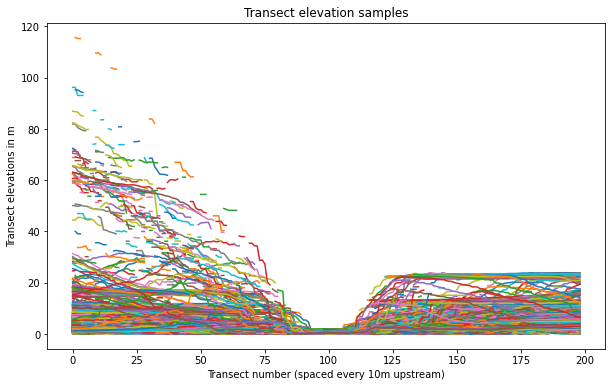

In [83]:
f, ax = matplotlib.pyplot.subplots(figsize=(10, 6))
for elevations, min_z in zip(transect_samples['elevations'], transect_samples['min_z']):
    matplotlib.pyplot.plot(elevations - min_z)
ax.set(title="Transect elevation samples")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel("Transect elevations in m");

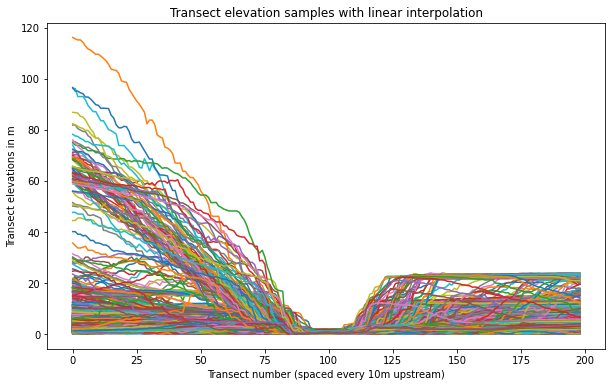

In [84]:
f, ax = matplotlib.pyplot.subplots(figsize=(10, 6))
for elevations, min_z in zip(transect_samples_linear['elevations'], transect_samples_linear['min_z']):
    matplotlib.pyplot.plot(elevations - min_z)
ax.set(title=f"Transect elevation samples with linear interpolation")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel("Transect elevations in m");

# Calculate width and slope
Use the linear interpolation as we have results everywhere

In [30]:
def width_from_samples(transects: geopandas.GeoDataFrame, transect_samples: dict, threshold: float, resolution: float):
    
    widths = {'widths': [], 'first_widths': [], 'last_widths': []}
    
    for j in range(len(transect_samples['elevations'])):
    
        assert numpy.floor(len(transect_samples['elevations'][j])/2) != len(transect_samples['elevations'][j])/2, "Expect an odd length"
        start_i = numpy.nan
        stop_i = numpy.nan
        centre_index = int(numpy.floor(len(transect_samples['elevations'][j])/2))
        
        for i in numpy.arange(0, centre_index, 1):
            # work forward checking height
            if transect_samples['elevations'][j][centre_index + i] - transects.loc[j]['upstream_min_z'] > threshold and numpy.isnan(stop_i):
                stop_i = centre_index + i
            # work backward checking height
            if transect_samples['elevations'][j][centre_index - i] - transects.loc[j]['upstream_min_z'] > threshold and numpy.isnan(start_i):
                start_i = centre_index - i
        
        widths['first_widths'].append((centre_index-start_i)*resolution)
        widths['last_widths'].append((stop_i-centre_index)*resolution)
        widths['widths'].append((stop_i - start_i)*resolution)
    
    return widths

In [31]:
def width_from_samples_zeroed(transects: geopandas.GeoDataFrame, transect_samples: dict, threshold: float, resolution: float):
    
    widths = {'widths': [], 'first_widths': [], 'last_widths': []}
    
    for j in range(len(transect_samples['elevations'])):
        
        zeroed_elevations = transect_samples['elevations'][j]-transects.loc[j]['mean_min_z']
    
        assert numpy.floor(len(zeroed_elevations)/2) != len(zeroed_elevations)/2, "Expect an odd length"
        start_i = numpy.nan
        stop_i = numpy.nan
        centre_index = int(numpy.floor(len(zeroed_elevations)/2))
        
        for i in numpy.arange(0, centre_index, 1):
            # work forward checking height
            if zeroed_elevations[centre_index + i] - zeroed_elevations[centre_index] > threshold and numpy.isnan(stop_i):
                stop_i = centre_index + i
            # work backward checking height
            if zeroed_elevations[centre_index - i] - zeroed_elevations[centre_index] > threshold and numpy.isnan(start_i):
                start_i = centre_index - i
        
        widths['first_widths'].append((centre_index-start_i)*resolution)
        widths['last_widths'].append((stop_i-centre_index)*resolution)
        widths['widths'].append((stop_i - start_i)*resolution)
    
    return widths

## Plot channel surface elevation

Calculate the rolling average of minimum elevations - note same for samples and linear interpolated samples

In [32]:
transects['min_z'] = transect_samples['min_z']
transects['mean_min_z'] = transects['min_z'].rolling(5, center=True).mean()
transects.loc[numpy.isnan(transects['mean_min_z']), ('mean_min_z')] = transects['min_z'][numpy.isnan(transects['mean_min_z'])]

Calculate the minimum upstream river depth

In [33]:
min_z = transects['mean_min_z']
upstream_min_z = numpy.zeros(len(min_z))
upstream_min_z[-1] = min_z[len(min_z) - 1]
for i in range(len(min_z) - 2, -1, -1): # range [len-1, len-2, len-3, ..., 2, 1, 0]
    upstream_min_z[i] = min_z[i] if min_z[i] < upstream_min_z[i + 1] else upstream_min_z[i + 1]
transects['upstream_min_z'] = upstream_min_z

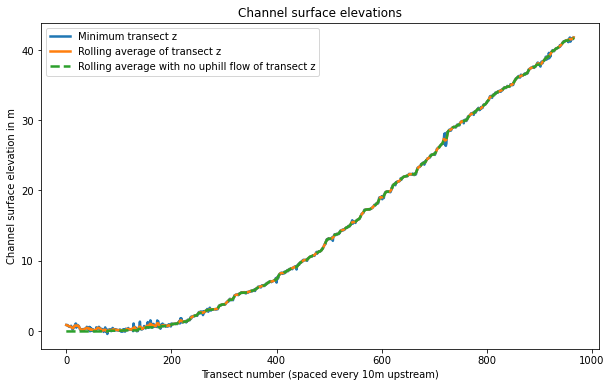

In [95]:
f, ax = matplotlib.pyplot.subplots(figsize=(10, 6))
transects['min_z'].plot(linewidth=2.5, ax=ax, label="Minimum transect z")
transects['mean_min_z'].plot(linewidth=2.5, ax=ax, label="Rolling average of transect z")
transects['upstream_min_z'].plot(linestyle='--', linewidth=2.5, ax=ax, label="Rolling average with no uphill flow of transect z")
ax.set(title=f"Channel surface elevations")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"Channel surface elevation in m")
ax.legend();

## Calculate slope

In [73]:
transects['slope'] = transects['upstream_min_z'].diff()/transects['length']

Text(0, 0.5, 'Channel Channel slope')

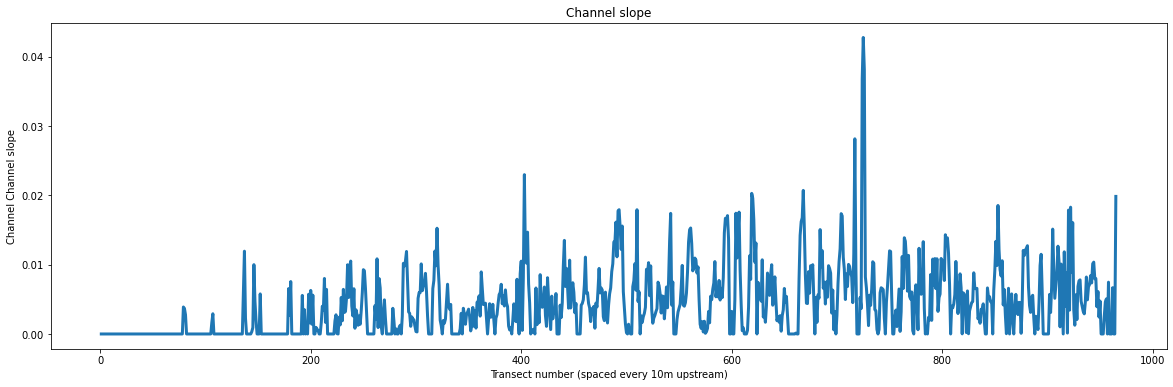

In [74]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 6))
transects['slope'].plot(linewidth=3, ax=ax, label="Channel slope")
ax.set(title=f"Channel slope")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"Channel Channel slope")

## Calculate widths

In [34]:
threshold = 1
widths_linear = width_from_samples(transects, transect_samples_linear, threshold, resolution)
widths = width_from_samples(transects, transect_samples, threshold, resolution)

In [35]:
widths_input = widths

In [36]:
def apply_bank_width(midpoint, nx, ny, first_widths, last_widths):
    
    return shapely.geometry.LineString([[midpoint.x - first_widths * nx, midpoint.y - first_widths * ny],
                                                      midpoint,
                                                      [midpoint.x + last_widths * nx, midpoint.y + last_widths * ny]])

In [37]:
transects['width'] = widths_input['widths']
transects['first_widths'] = widths_input['first_widths']
transects['last_widths'] = widths_input['last_widths']

transects['width_line'] = transects.apply(lambda x: apply_bank_width(x['midpoint'], x['nx'], x['ny'], x['first_widths'], x['last_widths']), axis=1)

In [38]:
transects.loc[transects['width']==0, ('width')] = numpy.nan

In [39]:
display_line_widths = geopandas.GeoDataFrame(geometry=transects['width_line'][~numpy.isnan(transects['width'])], crs=transects.crs)

## Plot width on line plot with elevation transect

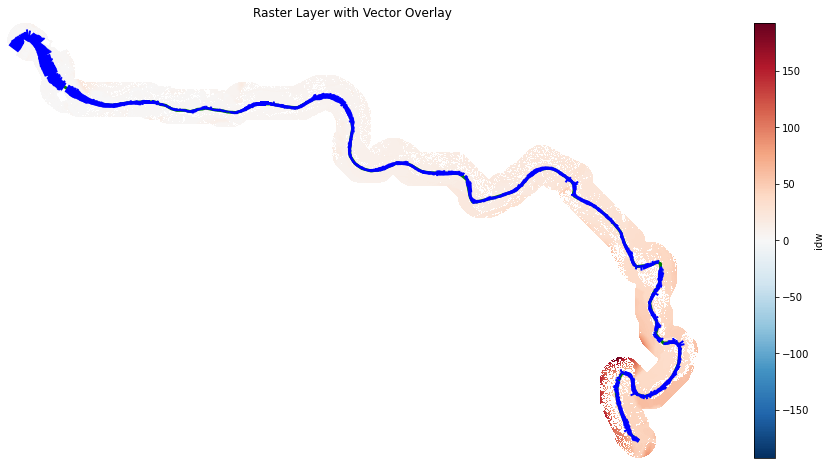

In [40]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 8))

waikane_dem.plot(ax=ax)

waikanae_manual_rivers[waikanae_manual_rivers['id']==0].plot(color='green', linewidth=3, ax=ax)

display_line_widths.plot(color='blue',
                    edgecolor='teal',
                    linewidth=2,
                    ax=ax)

ax.set(title="Raster Layer with Vector Overlay")
ax.axis('off')
matplotlib.pyplot.show()

### Save out results
* Table: 10m spaced width, height and slope values along the reach - alongside the midpoint values
* Plot: width as a line over the LiDAR - will need the midpoint, nx, ny, and start and stop indices

In [41]:
transects.drop(columns=['midpoint', 'width_line']).to_file(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_trasects_mean_depth_{sampling_resolution}m_downriver_{threshold}m_bank_thresh_upstream_linear_2_3.geojson")
display_line_widths.to_file(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_width_mean_depth_{sampling_resolution}m_downriver_{threshold}m_bank_thresh_upstream_linear2_3.geojson")

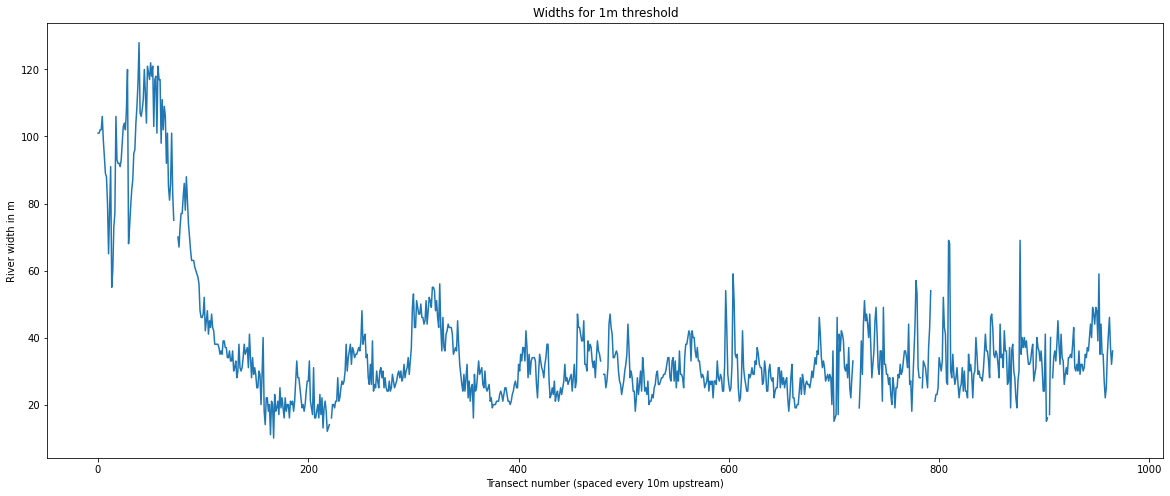

In [42]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 8))
transects['width'].plot(ax=ax)
ax.set(title=f"Widths for {threshold}m threshold")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River width in m");

In [ ]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 8))
transects['width'].plot(ax=ax)
ax.set(title=f"Widths for {threshold}m threshold")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River width in m");

In [ ]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 8))
transects['width'].plot(ax=ax)
ax.set(title=f"Widths for {threshold}m threshold")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River width in m");

## Plot bank locations alongside transects on DEM in plan view

## Save out river bank points or width lines

In [43]:
flat_waikanae_river_area.head(5)

,HydroID,NextDownID,CATAREA,CUM_AREA,nzsegment,Enabled,LENGTHDOWN,Headwater,Hydseq,StreamOrde,...,nzreach_re,headw_dist,segslpmax,segslpmean,LID,reachtype,FROM_NODE,TO_NODE,Shape_Leng,geometry
253495,253496,0,18001.0,152753696.0,9253579,1,0.000000,0,256825,5,...,9003742,24527,0.000000,0.000000,0,0,259082,259083,15.000400,"LINESTRING (1769118.631 5473462.110, 1769103.6..."
253530,253531,9253579,72004.1,151917552.0,9253587,1,15.000400,0,256824,5,...,9003756,24512,0.002054,0.000469,0,0,259120,259082,344.568295,"LINESTRING (1769358.632 5473252.097, 1769358.6..."
253612,253613,9253587,239414.0,142299648.0,9253625,1,359.568695,0,256823,5,...,9003855,24167,8.140000,3.140000,0,0,259213,259120,847.303839,"LINESTRING (1769958.641 5472952.071, 1769568.6..."
253627,253628,9253625,112506.9,141125072.0,9253707,1,1206.872535,0,256822,5,...,9003869,23320,6.550000,2.700000,0,0,259228,259213,414.865601,"LINESTRING (1770348.651 5472892.057, 1770318.6..."
253638,253639,9253707,150309.7,140436528.0,9253724,1,1621.738136,0,256821,5,...,9003869,22905,1.010000,0.700000,0,0,259238,259228,462.441151,"LINESTRING (1770798.664 5472862.042, 1770768.6..."


# Find which reach id a section intersects with

In [50]:
transects_to_matt = transects.drop(columns=['nx', 'ny', 'length', 'min_z', 'first_widths', 'last_widths', 'width_line', 'mean_min_z', 'upstream_min_z'])
transects_to_matt['nzsegment'] = numpy.zeros(len(transects_to_matt['width']), dtype=int) * -1
for i, row in flat_waikanae_river_area.iterrows():
    transects_to_matt.loc[transects_to_matt.intersects(row.geometry), ('nzsegment')] = row['nzsegment']
transects_to_matt['nzreach_re'] = numpy.zeros(len(transects_to_matt['width']), dtype=int) * -1
for i, row in flat_waikanae_river_area.iterrows():
    transects_to_matt.loc[transects_to_matt.intersects(row.geometry), ('nzreach_re')] = row['nzreach_re']

In [45]:
transects_to_matt.to_csv(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_river_widths_at_{sampling_resolution}m_upriver_spacing_{threshold}m_bank_threshold_upstream2_3.csv")

In [51]:
transects_to_matt.drop(columns=['midpoint']).to_file(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_river_widths_at_{sampling_resolution}m_upriver_spacing_{threshold}m_bank_threshold_upstream_2_3.geojson")

In [94]:
transects_to_matt.set_geometry('midpoint', drop=True).to_file(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_river_widths_at_{sampling_resolution}m_upriver_spacing_{threshold}m_bank_threshold_upstream_2_3_midpoint.geojson")

In [49]:
flat_waikanae_river_area.head()

,HydroID,NextDownID,CATAREA,CUM_AREA,nzsegment,Enabled,LENGTHDOWN,Headwater,Hydseq,StreamOrde,...,nzreach_re,headw_dist,segslpmax,segslpmean,LID,reachtype,FROM_NODE,TO_NODE,Shape_Leng,geometry
253495,253496,0,18001.0,152753696.0,9253579,1,0.000000,0,256825,5,...,9003742,24527,0.000000,0.000000,0,0,259082,259083,15.000400,"LINESTRING (1769118.631 5473462.110, 1769103.6..."
253530,253531,9253579,72004.1,151917552.0,9253587,1,15.000400,0,256824,5,...,9003756,24512,0.002054,0.000469,0,0,259120,259082,344.568295,"LINESTRING (1769358.632 5473252.097, 1769358.6..."
253612,253613,9253587,239414.0,142299648.0,9253625,1,359.568695,0,256823,5,...,9003855,24167,8.140000,3.140000,0,0,259213,259120,847.303839,"LINESTRING (1769958.641 5472952.071, 1769568.6..."
253627,253628,9253625,112506.9,141125072.0,9253707,1,1206.872535,0,256822,5,...,9003869,23320,6.550000,2.700000,0,0,259228,259213,414.865601,"LINESTRING (1770348.651 5472892.057, 1770318.6..."
253638,253639,9253707,150309.7,140436528.0,9253724,1,1621.738136,0,256821,5,...,9003869,22905,1.010000,0.700000,0,0,259238,259228,462.441151,"LINESTRING (1770798.664 5472862.042, 1770768.6..."


In [96]:
transects_to_matt.set_geometry('midpoint', drop=True)

,geometry,width,slope,nzsegment,nzreach_re
0,POINT (1769005.950 5473399.102),101.0,NaN,0,0
1,POINT (1769011.984 5473407.076),101.0,0.000000,0,0
2,POINT (1769018.019 5473415.050),102.0,0.000000,0,0
3,POINT (1769024.053 5473423.024),102.0,0.000000,0,0
4,POINT (1769030.088 5473430.998),106.0,0.000000,0,0
...,...,...,...,...,...
961,POINT (1774362.861 5470035.952),41.0,0.000000,9254385,9004639
962,POINT (1774370.608 5470029.647),46.0,0.006682,9254385,9004639
963,POINT (1774378.790 5470023.943),37.0,0.000000,9254385,9004639
964,POINT (1774387.302 5470018.696),32.0,0.000000,9254385,9004639
